In [ ]:
!pip install qiskit
!pip install qiskit-machine-learning
!pip install qiskit-optimization

# Clasificador Booleano de Números

Este notebook se basa altamente en los tutoriales de Qiskit. Lo que se ha modificado drásticamente son los datos de entrada. 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
import torch.nn.functional as F
from torch.optim import LBFGS
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, ToPILImage

from PIL import Image

from qiskit  import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

# DataSet

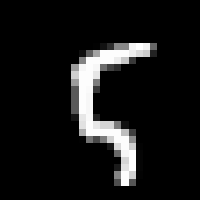

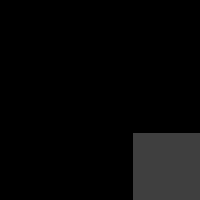

24
24
200
200
tensor([9, 5, 5, 9, 9, 5, 5, 5, 9, 9, 5, 9, 9, 5, 5, 9, 5, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 5, 9, 9, 9, 9, 5, 9, 5, 9, 9, 9, 9, 9, 5, 9, 9, 9, 5, 5,
        5, 5, 9, 5, 9, 9, 5, 5, 5, 9, 5, 5, 5, 5, 5, 9, 9, 5, 5, 5, 5, 9, 5, 9,
        5, 9, 5, 5, 5, 9, 5, 5, 9, 9, 5, 9, 5, 9, 9, 5, 5, 5, 9, 5, 5, 9, 9, 9,
        5, 5, 9, 9, 9, 5, 5, 9, 5, 9, 5, 5, 5, 9, 9, 5, 5, 5, 5, 5, 5, 5, 5, 9,
        5, 9, 9, 5, 5, 5, 9, 5, 5, 5, 9, 5, 9, 9, 5, 9, 9, 9, 5, 5, 9, 9, 9, 9,
        9, 5, 9, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 9, 9, 9, 5, 9, 9, 5, 9, 5, 9, 9,
        9, 5, 9, 9, 9, 9, 5, 9, 9, 9, 5, 5, 5, 9, 5, 5, 9, 5, 9, 5, 5, 9, 5, 9,
        5, 5, 5, 9, 9, 5, 9, 5])
test images comprobation:


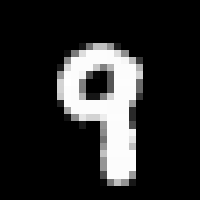

tensor(0)


In [109]:
#Train Data
#Si se tarda, es por que se está descargando a info de MNIST

#Esto es MUY importante. Entre más pixeles mas lento el proceso
side_pixels=3 #side_pixels^2 es el numero de qbits. 

# Concentrating on the first 100 samples
n_samples = 12 #12 de cada número

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 9 and 5 
idx = np.append(np.where(X_train.targets == 5)[0][:n_samples], 
                np.where(X_train.targets == 9)[0][:n_samples])

random.shuffle(idx)

X_train.data = X_train.data[idx] #Data contiene información de las imagenes en matriz.



#Redimensionamiento
random_img=np.random.randint(0, high=len(X_train.data))
sample=X_train.data
sample=sample[None, :, :, :]
out1 = F.interpolate(sample, size=(side_pixels, side_pixels))
simg=ToPILImage()(sample[0][random_img])
img = ToPILImage()(out1[0][random_img])

display(simg.resize((40 * 5, 40 * 5), Image.NEAREST))
display(img.resize((40 * 5, 40 * 5), Image.NEAREST))
img.show()

X_train.data=out1[0]
Xtrain=torch.tensor([list(torch.flatten(data)) for data in X_train.data])/255
print(len(Xtrain))

X_train.targets = X_train.targets[idx] #Targets son los labels
Map=lambda i: 1 if i==5 else 0 #Long function
Ytrain = torch.tensor([Map(x) for x in X_train.targets])

#print(X_train.data[0]) #Veelo por ti mismo

print(len(Ytrain))

#-----------------------------------

#Test Data

n_samples = 100

#Now train=False, this are images for testing
X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 5)[0][:n_samples], 
                np.where(X_test.targets == 9)[0][:n_samples])
random.shuffle(idx)

X_test.data = X_test.data[idx]

random_img=np.random.randint(0, high=len(X_test.data))
sample=X_test.data
sample=sample[None, :, :, :]
out1 = F.interpolate(sample, size=(side_pixels, side_pixels))

X_test.data=out1[0]
print(len(X_test.data))

Xtest=torch.tensor([list(torch.flatten(data)) for data in X_test.data])/255
print(len(Xtest))

X_test.targets = X_test.targets[idx]
print(X_test.targets)
Ytest = torch.tensor([Map(x) for x in X_test.targets])


n=4
simg=ToPILImage()(sample[0][n])

print("test images comprobation:")
display(simg.resize((40 * 5, 40 * 5), Image.NEAREST))
print(Ytest[n])





# Quantum Circuit Neural Network

In [20]:
quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator'), shots=1024)

num_inputs=int(side_pixels**2)
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, entanglement='linear', reps=1)

# Define quantum circuit of num_qubits = input dim
# Append feature map and ansatz
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))


# Define CircuitQNN and initial setup
parity = lambda x: '{:b}'.format(x).count('1') % 2 # optional interpret function
output_shape = 2  # parity = 0, 1
qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters,
                  interpret=parity, output_shape=output_shape, quantum_instance=quantum_instance)

# Set up PyTorch module
# Reminder: If we don't explicitly declare the initial weights
# they are chosen uniformly at random from [-1, 1].
np.random.seed(9)
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
print("Initial weights: ", initial_weights)
model2 = TorchConnector(qnn2, initial_weights)

Initial weights:  [-0.09792517  0.00037492 -0.00084534 -0.07323409 -0.07157778 -0.05628826
 -0.01629836 -0.05037977 -0.08318807 -0.03090027 -0.06664473  0.07571182
  0.09019281 -0.09225032  0.03982148  0.01455196  0.07960142  0.03337979]


In [26]:

# Define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss() # Our output will be in the [0,1] range

# Start training
model2.train()

# Define LBFGS closure method (explained in previous section)
def closure():
    optimizer.zero_grad(set_to_none=True)                  # Initialize gradient
    loss = f_loss(model2(Xtrain), Ytrain)                        # Calculate loss
    loss.backward()                                        # Backward pass

    print(loss.item())                                     # Print loss
    return loss

# Run optimizer (LBFGS requires closure)
optimizer.step(closure);

0.6852800846099854
0.6880813241004944
0.6832675933837891
0.6911059021949768
0.6946389079093933
0.6887882351875305
0.6781919002532959
0.7043651938438416
0.6933479905128479
0.6784207820892334
0.6956479549407959
0.6901163458824158
0.6940956115722656
0.7036826610565186
0.7005148530006409
0.693030595779419
0.6913158893585205
0.6902520656585693
0.693662703037262
0.6910346150398254


# Resultados

In [105]:
#Test images calssification
#Esto se comprobará en la siguientes celdas, donde se volvio a ejecutar la 
#celda que generá test data para así proveer diferentes resultados
y_predict = []
for x in Xtest:
    output = model2(x)
    y_predict += [np.argmax(output.detach().numpy())]
    #print("Valor de la etiqueta: {}".format(Ytest[i]))
    #print("Valor de la predicción: {}".format(y_predict[i]))

In [97]:
#Para datos generados al azar: Sample
i=0
sum=0
for prediction in y_predict:
  if y_predict[i]==Ytest[0]:
    sum+=1
  i+=1
accur=sum/len(Ytest)

print('Accuracy:', accur)
print(y_predict)
print(Ytest)

Accuracy: 0.84
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
tensor([0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
        1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
        1, 1])


In [106]:
#Para datos generados al azar: Sample 2 #aqui use 200 samples
i=0
sum=0
for prediction in y_predict:
  if y_predict[i]==Ytest[0]:
    sum+=1
  i+=1
accur=sum/len(Ytest)

print('Accuracy:', accur)
print(y_predict)
print(Ytest)

Accuracy: 0.86
[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0]
tensor([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,
        0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
        0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
        0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,

In [93]:
#Para datos generados al azar: Sample 2
i=0
sum=0
for prediction in y_predict:
  if y_predict[i]==Ytest[0]:
    sum+=1
  i+=1
accur=sum/len(Ytest)

print('Accuracy:', accur)
print(y_predict)
print(Ytest)

Accuracy: 0.82
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        0, 1])


# Análisis de Resultados
Se observa en el notebook anterior que el algoritmo de optimización no fue satisfactorio. Dejando la función de costo Más Elevada

La precisión resulta ser convenientemente baja o alta en la mayoría de las pruebas. Como las categorías son booleanas, muchas veces podemos invertir los resultados

Para obtener una precisión más justa:

Este feature no se ha desarrollado más debido a la falta de tiempo con la que nos quedamos.

This is a poor analysis, so better supervision should be done.

Number of tests could also be upgraded

# Referencias:
1. Documentación de Qiskit

- https://qiskit.org/documentation/machine-learning/tutorials/05_torch_connector.html

- https://qiskit.org/documentation/machine-learning/tutorials/02_neural_network_classifier_and_regressor.html

- https://qiskit.org/documentation/machine-learning/tutorials/01_neural_networks.html

- https://sooluthomas.github.io/testTranslation/aqua/feature_maps.html

2. Proyecto análogo hecho con Q Tensor Flow de Google

- https://thesai.org/Downloads/Volume11No10/Paper_40-Handwritten_Numeric_Image_Classification.pdf